# Simulation using Tweedie's formula for bias correction

Here's a cut out of the overleaf text to give context for the simulation:

> We start with the given relationship $Y = \hat{Y} + \epsilon_1$ where $\epsilon_1 \perp \hat{Y}$. $Y$ are the true wealth values and $\hat{Y}$ are the predictions from our model. Here, we add an assumption that $\epsilon_1$ is gaussian, i.e. $\epsilon_1 \sim \mathcal{N}(0, \sigma_1^2)$. This implies $Y \mid \hat{Y} \sim \mathcal{N}(\hat{Y}, \sigma_1^2)$.
> 
> According to Tweedie's formula, the posterior mean can be expressed as
> 
> \begin{equation}
>     \mathbb{E}[\hat{Y} \mid Y] = Y + \sigma_1^2 \frac{d}{dY} \log p_Y(Y)
> \end{equation}
> 
> where $p_Y(Y)$ is the marginal density of $Y$.
> 
> Interpretation: The expected predicted value $\hat{Y}$ for a given $Y$ will be close to $Y$, but slightly shifted in the direction where $Y$ is denser. That is, for a $Y$ in the tail, the predicted value will be closer to the center. This is what leads us to overestimate the wealth in poor regions and underestimate the wealth in rich regions. 

> ### Next step: Use this when estimating $\tau$
> 
> If we have
> 
> \begin{equation}
>     \tau = \mathbb{E}\left[ Y \mid A=1 \right] - \mathbb{E}\left[ Y \mid A=0 \right]
> \end{equation}
>
> and
> 
> \begin{equation}
>     \hat{\tau} = \mathbb{E}\left[ \hat{Y} \mid A=1 \right] - \mathbb{E}\left[ \hat{Y} \mid A=0 \right]
> \end{equation}
> 
> then (I believe) we should have
> 
> \begin{align}
>     \mathbb{E}\left[\hat{\tau} \mid \tau \right] &= \mathbb{E}\left[ \mathbb{E}[\hat{Y} \mid Y] \mid A=1 \right] - \mathbb{E}\left[ \mathbb{E}[\hat{Y} \mid Y] \mid A=0 \right] \\
>     &= \mathbb{E}\left[ Y + \sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=1 \right] - \mathbb{E}\left[ Y + \sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=0 \right] \\
>     &= \underbrace{\mathbb{E}\left[ Y \mid A=1 \right] - \mathbb{E}\left[ Y \mid A=0 \right]}_{\tau} + \mathbb{E}\left[ \sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=1 \right] - \mathbb{E}\left[\sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=0 \right] \\
>     &= \tau + \sigma_1^2 \left( \mathbb{E}\left[ \frac{d}{dY} \log p_Y(Y) \mid A=1 \right] - \mathbb{E}\left[\frac{d}{dY} \log p_Y(Y) \mid A=0 \right] \right)
> \end{align}

Let's see if this works with a simulation! We need to generate samples of $Y$ and $\hat{Y}$ to see if the treatment effects we capture ($\tau$ and $\hat{\tau}$) differ according to our formula. We start out by defining the marginal density $P_{\hat{Y}}(Y)$.

In [1]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

class MarginalYHat:
    def __init__(self, component_weights, component_means, component_std_devs):

        self.component_weights = component_weights
        self.component_means = component_means
        self.component_std_devs = component_std_devs

    def pdf(self, y_hat):
        pdf_value = 0
        for i in range(len(self.component_weights)):
            pdf_value += self.component_weights[i] * norm.pdf(y_hat, loc=self.component_means[i], scale=self.component_std_devs[i])
        return pdf_value
        
    def sample(self, num_samples):

        component_choices = np.random.choice(len(self.component_weights), size=num_samples, p=self.component_weights)
        samples = np.array([np.random.normal(self.component_means[i], self.component_std_devs[i]) for i in component_choices])

        return samples

Let's define our distribution for $\hat{Y}$. In theory, it should work for any distribution, but I define it as a mixture of Gaussians. The first "strata" will represent rural points. I say that 80% of points belong to this strata and that they (prior to treatment) have a mean wealth of 5 and a spread of 1. The remaining 20% belong to the urban strata and have both a higher mean and a higher spread, 13 and 4, respectively. This roughly reminds me of my memory of what the DHS distribution looks like. For each strate, I then take 20% of the points and increase them by a value $\tau_{\hat{Y}}$, simulating a treatment. This give me a mixture of Gaussian on the following form:

$$
P_{\hat{Y}}(y) = \underbrace{0.8 \cdot \left( 0.8 \cdot \mathcal{N}(y; 5, 1^2) + 0.2 \cdot \mathcal{N}(y; 5 + \tau_{\hat{Y}}, 1^2) \right)}_{\text{Rural}} + \underbrace{0.2 \cdot \left( 0.8 \cdot \mathcal{N}(y; 13, 4^2) + 0.2 \cdot \mathcal{N}(y; 13 + \tau_{\hat{Y}}, 4^2) \right)}_{\text{Urban}}
$$

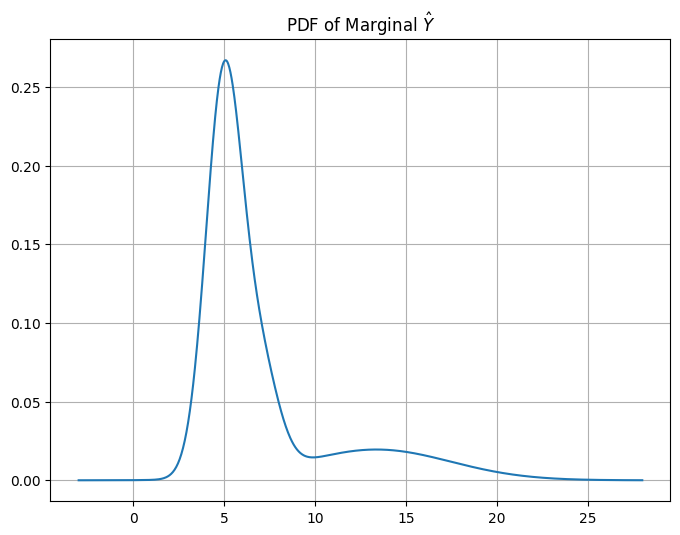

In [2]:
# Define the parameters for the mixture of Gaussians
component_weights = np.asarray([0.64, 0.16, 0.16, 0.04])  # Weights for each component
component_means = np.asarray([5, 7, 13, 15])  # Means for each component
component_std_devs = np.asarray([1, 1, 4, 4])  # Standard deviations for each component

# Create the marginal Y_hat object
marginal_Y_hat = MarginalYHat(component_weights, component_means, component_std_devs)

# Plot the PDFs
y_values = np.linspace(-3, 28, 1000)
pdf_hat_values = np.array([marginal_Y_hat.pdf(y_hat) for y_hat in y_values])

plt.figure(figsize=(8, 6))
plt.plot(y_values, pdf_hat_values, label='PDF')
plt.title('PDF of Marginal $\hat{Y}$')
plt.grid(True)
plt.show()

We need to also get an expression for $Y$. Since we assumed above that $Y = \hat{Y} + \mathcal{N}(0, \sigma^2)$ we create such a class.

In [3]:
class MarginalY:
    def __init__(self, marginal_y_hat, sigma_y, component_treatment_status):
        #self.marginal_y_hat = marginal_y_hat
        #self.sigma_y = sigma_y

        self.sigma_y = sigma_y
        self.component_weights = marginal_y_hat.component_weights
        self.component_means = marginal_y_hat.component_means
        self.component_std_devs = marginal_y_hat.component_std_devs ** 2 + sigma_y ** 2  # Add the variance of Y to the variance of the component
        self.component_treatment_status = component_treatment_status
    
    def pdf(self, y_hat, t=None):
        pdf_value = 0

        if t is None:
            # Use all components
            pdf_component_weights = self.component_weights
            pdf_component_means = self.component_means
            pdf_component_std_devs = self.component_std_devs
        else:
            # Use only the components for the given treatment status
            pdf_components = np.where(self.component_treatment_status == t)[0]
            pdf_component_weights = self.component_weights[pdf_components]
            pdf_component_means = self.component_means[pdf_components]
            pdf_component_std_devs = self.component_std_devs[pdf_components]

        for i in range(len(pdf_component_weights)):
            pdf_value += pdf_component_weights[i] * norm.pdf(y_hat, loc=pdf_component_means[i], scale=np.sqrt(pdf_component_std_devs[i]))
        return pdf_value
    
    def sample(self, num_samples, t=None):

        if t is None:
            # Use all components
            sample_component_weights = self.component_weights
            sample_component_means = self.component_means
            sample_component_std_devs = self.component_std_devs
        else:
            # Use only the components for the given treatment status
            sample_components = np.where(self.component_treatment_status == t)[0]
            sample_component_weights = self.component_weights[sample_components]
            sample_component_weights /= np.sum(sample_component_weights)  # Normalize the weights
            sample_component_means = self.component_means[sample_components]
            sample_component_std_devs = self.component_std_devs[sample_components]

        component_choices = np.random.choice(len(sample_component_weights), size=num_samples, p=sample_component_weights)
        samples = np.array([np.random.normal(sample_component_means[i], np.sqrt(sample_component_std_devs[i])) for i in component_choices])

        return samples

    def get_tau(self):
        treated_components = np.where(marginal_Y.component_treatment_status)[0]
        control_components = np.where(~marginal_Y.component_treatment_status)[0]

        treated_means = marginal_Y.component_means[treated_components]
        control_means = marginal_Y.component_means[control_components]
        treated_weights = marginal_Y.component_weights[treated_components]
        control_weights = marginal_Y.component_weights[control_components]

        tau = np.average(treated_means, weights=treated_weights) - np.average(control_means, weights=control_weights)
        return tau
    
    def score(self, y):
        pdf_value = self.pdf(y)  # Compute p_Y(Y)
        if pdf_value == 0:
            return 0  # Avoid division by zero
        
        score_value = 0
        for i in range(len(self.component_weights)):
            component_pdf = norm.pdf(y, loc=self.component_means[i], scale=np.sqrt(self.component_std_devs[i]))
            score_value += self.component_weights[i] * -((y - self.component_means[i]) / self.component_std_devs[i]) * component_pdf

        return score_value / pdf_value  # Compute d/dY log p_Y(Y)


Let's plot the marginal distributions of $Y$ and $\hat{Y}$.

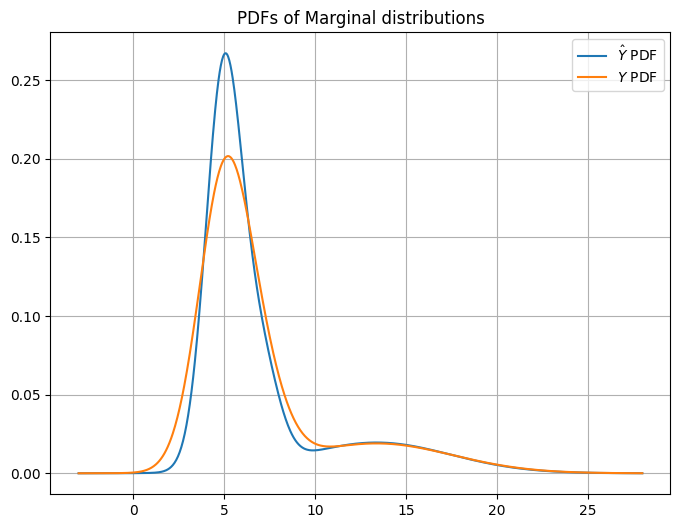

In [4]:
# Create the marginal Y object
sigma_y = 1.0
component_treatment_status = np.array([False, True, False, True])
marginal_Y = MarginalY(marginal_Y_hat, sigma_y, component_treatment_status)

# Plot the PDFs
pdf_values = np.array([marginal_Y.pdf(y) for y in y_values])

plt.figure(figsize=(8, 6))
plt.plot(y_values, pdf_hat_values, label='$\hat{Y}$ PDF')
plt.plot(y_values, pdf_values, label='$Y$ PDF')
plt.title('PDFs of Marginal distributions')
plt.legend()
plt.grid(True)
plt.show()

We see that $\hat{Y}$ roughly follows the shape of $Y$, but with the densities more concentrated around the modes. This gives a smaller variance, which is in line with our expectations.

We can also plot the conditional distributions on treatment

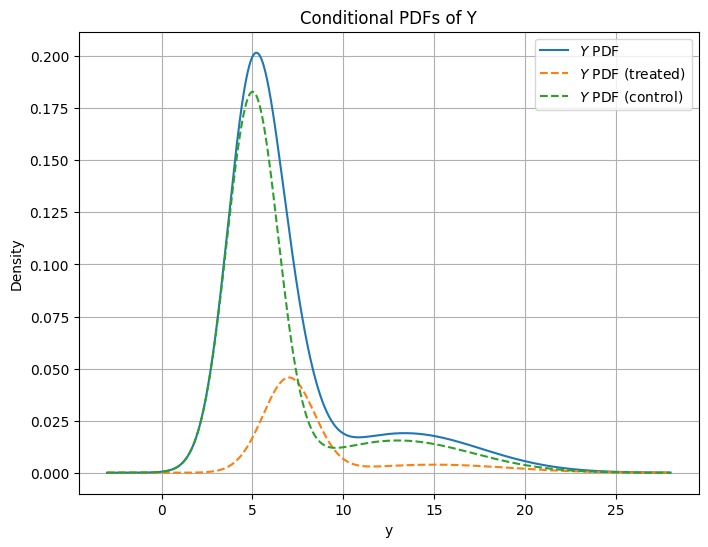

True ATE: 2.0


In [5]:
# Get the conditional PDFs
pdf_t_values = np.array([marginal_Y.pdf(y, t=True) for y in y_values])
pdf_c_values = np.array([marginal_Y.pdf(y, t=False) for y in y_values])

plt.figure(figsize=(8, 6))
plt.plot(y_values, pdf_values, label='$Y$ PDF')
plt.plot(y_values, pdf_t_values, '--', label='$Y$ PDF (treated)')
plt.plot(y_values, pdf_c_values, '--', label='$Y$ PDF (control)')
plt.xlabel('y')
plt.ylabel('Density')
plt.title('Conditional PDFs of Y')
plt.legend()
plt.grid(True)
plt.show()

print(f'True ATE: {marginal_Y.get_tau()}')

Now, let's also plot the score function for $Y$

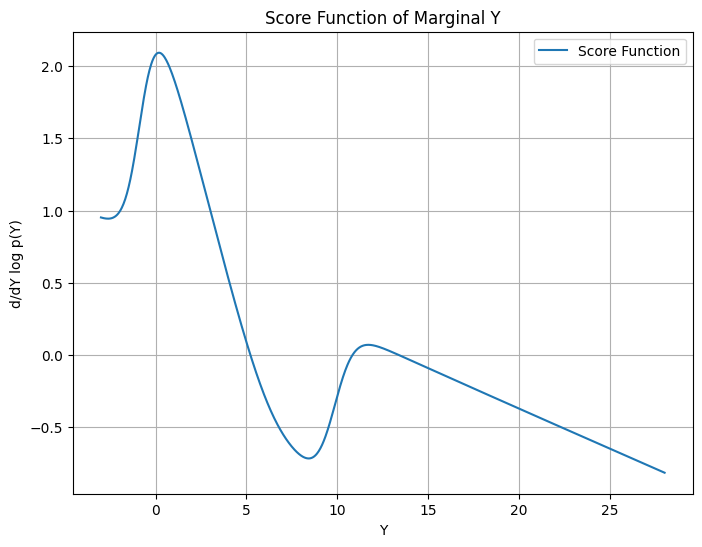

In [6]:
# Plot the score function
y_score_values = np.array([marginal_Y.score(y) for y in y_values])

plt.figure(figsize=(8, 6))
plt.plot(y_values, y_score_values, label='Score Function')
plt.xlabel('Y')
plt.ylabel('d/dY log p(Y)')
plt.title('Score Function of Marginal Y')
plt.legend()
plt.grid(True)
plt.show()

This looks reasonable, with $\frac{d}{dY} \log p(Y)$ following what we expect from the curve in the previous plot (e.g. is 0 at the local max- and minima, positive on the left and negative on the right)

We can use Baye's theorem to obtain the posterior distribution:

$$
p(\hat{Y} \mid Y) = \frac{p(Y \mid \hat{Y})\, p(\hat{Y})}{p(Y)} 
$$

In [ ]:
def p_yhat_y(y_hat, y, marginal_Y_hat, marginal_Y):
    
    # Use Bayes' theorem to compute p(Y_hat|Y)
    p_yhat = marginal_Y_hat.pdf(y_hat)
    p_y_yhat = norm.pdf(y, loc=y_hat, scale=marginal_Y.sigma_y)
    p_y = marginal_Y.pdf(y)
    
    return p_y_yhat * p_yhat / p_y

Let's plot this for some samples, showing the ditribution of $p(\hat{Y} \mid Y)$

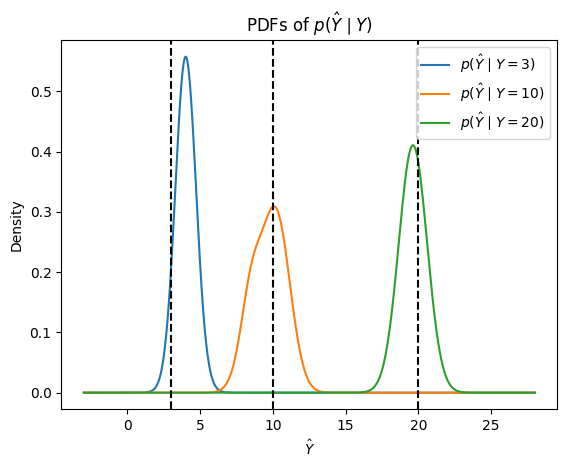

In [ ]:
# Plot PDF of p(Y_hat|Y)
y1 = 3
y2 = 10
y3 = 20
plt.plot(y_values, np.array([p_yhat_y(y_hat, y1, marginal_Y_hat, marginal_Y) for y_hat in y_values]), label='$p(\hat{Y} \mid Y=$' + str(y1) + ')')
plt.plot(y_values, np.array([p_yhat_y(y_hat, y2, marginal_Y_hat, marginal_Y) for y_hat in y_values]), label='$p(\hat{Y} \mid Y=$' + str(y2) + ')')
plt.plot(y_values, np.array([p_yhat_y(y_hat, y3, marginal_Y_hat, marginal_Y) for y_hat in y_values]), label='$p(\hat{Y} \mid Y=$' + str(y3) + ')')

# Plot vertical lines for the true values
plt.axvline(x=y1, color='k', linestyle='--')
plt.axvline(x=y2, color='k', linestyle='--')
plt.axvline(x=y3, color='k', linestyle='--')
plt.xlabel('$\hat{Y}$')
plt.ylabel('Density')
plt.title('PDFs of $p(\hat{Y} \mid Y)$')
plt.legend()
plt.show()

As we expected, the distributions $p(\hat{Y} \mid Y)$ is pulled closer to the higher density areas compared to $Y$.

There's likely a closed-form way to sample from $p(\hat{Y} \mid Y)$ as described above, but as I can't figure it out atm I'll just do stepwise sampling instead.

In [ ]:
def samply_y_hat_given_y(y, marginal_Y_hat, marginal_Y, n_samples=10000):
    
    y_hat_values = np.linspace(-3, 28, 1000)
    probabilities = np.array([p_yhat_y(y_hat, y, marginal_Y_hat, marginal_Y) for y_hat in y_hat_values])

    y_hat_samples = y_hat_values[np.random.choice(len(y_hat_values), size=n_samples, p=probabilities / np.sum(probabilities))]
    return y_hat_samples

Let's plot samples for a given $Y$ versus our calculated PDF. The results look correct.

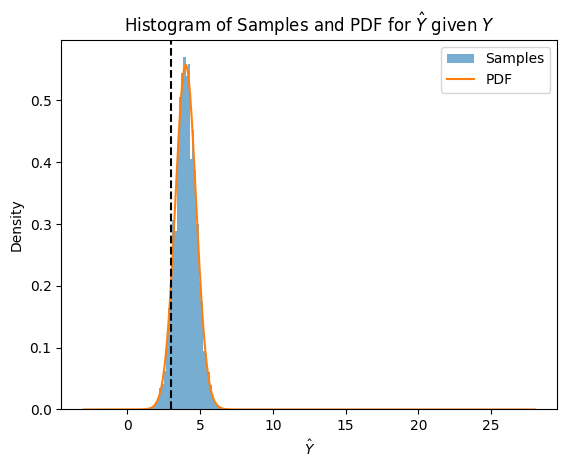

In [ ]:
# Plot PDF and sample histogramT
y = 3
y_hat_samples_given_y = samply_y_hat_given_y(y, marginal_Y_hat, marginal_Y)

plt.hist(y_hat_samples_given_y, bins=50, density=True, alpha=0.6, label='Samples')
plt.plot(y_values, np.array([p_yhat_y(y_hat, y, marginal_Y_hat, marginal_Y) for y_hat in y_values]), label='PDF')
plt.axvline(x=y, color='k', linestyle='--')
plt.xlabel('$\hat{Y}$')
plt.ylabel('Density')
plt.title('Histogram of Samples and PDF for $\hat{Y}$ given $Y$')
plt.legend()
plt.show()

### Running the simulation

Let's generate a sample for $Y$ and $\hat{Y}$ so we can compute and compare $\tau$ with $\hat{\tau}$! We start out by drawing some samples for $Y$, conditioned on the treatment status.

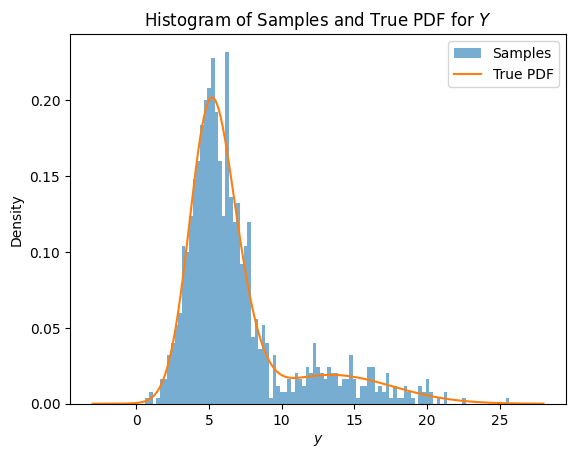

In [9]:
n_samples = 1000
n_t_samples = int(0.2 * n_samples)
n_c_samples = n_samples - n_t_samples

control_y_samples = marginal_Y.sample(n_c_samples, t=False)
treated_y_samples = marginal_Y.sample(n_t_samples, t=True)
y_samples = np.concatenate([control_y_samples, treated_y_samples])
t_samples = np.concatenate([np.zeros(n_c_samples, dtype=bool), np.ones(n_t_samples, dtype=bool)])

# Plot the histogram of the samples with the true PDF
plt.hist(y_samples, bins=100, density=True, alpha=0.6, label='Samples')
plt.plot(y_values, pdf_values, label='True PDF')
plt.xlabel('$y$')
plt.ylabel('Density')
plt.title('Histogram of Samples and True PDF for $Y$')
plt.legend()
plt.show()

Let's now sample corresponding $\hat{Y}$. For each true label $Y_i$ I draw 1000 model predictions $\hat{Y}_i$. This is done so we can plot a histogram over $\hat{\tau} \mid \tau$. As the sampling procedure is rather slow, it will take a while.

In [10]:
from tqdm import tqdm

y_hat_samples = np.array([samply_y_hat_given_y(y, marginal_Y_hat, marginal_Y, n_samples=1000) for y in tqdm(y_samples)])
y_hat_samples.shape

100%|██████████| 1000/1000 [10:51<00:00,  1.53it/s]


(1000, 1000)

Plot our drawn $\hat{Y}$ samples to compare to the theoretical PDF of $\hat{Y}$

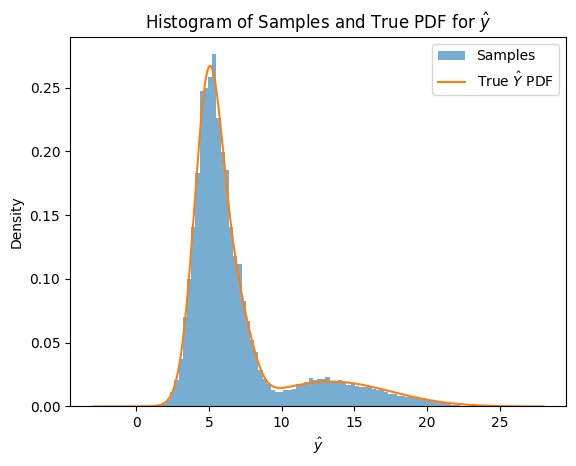

In [22]:
# Plot the histogram of the samples with the true PDF
plt.hist(y_hat_samples.flatten(), bins=100, density=True, alpha=0.6, label='Samples')
plt.plot(y_values, pdf_hat_values, label='True $\hat{Y}$ PDF')
plt.xlabel('$\hat{y}$')
plt.ylabel('Density')
plt.title('Histogram of Samples and True PDF for $\hat{y}$')
plt.legend()
plt.show()

Calculate the sample ATE using $\hat{Y}$ and $Y$. We expect $\tau$ (True Y sample ATE) to be 2.0 and $\hat{\tau}$ (Y Hat sample ATE) to be smaller than this.

In [23]:
# Calculate the ATE from the samples
hat_ate_estimates = np.mean(y_hat_samples[t_samples], axis=0) - np.mean(y_hat_samples[~t_samples], axis=0)
ate_estimate = np.mean(y_samples[t_samples]) - np.mean(y_samples[~t_samples])
print(f'Y Hat sample ATE: {np.mean(hat_ate_estimates)}')
print(f'True Y sample ATE: {ate_estimate}')

Y Hat sample ATE: 1.0552530718218234
True Y sample ATE: 1.5451082795882183


In this round, $\tau$ was rather small, presumably just an effect of the small sample size (the previous run it was >2.0. I'll rerun overnight with a larger sample). As expected, $\tau > \hat{\tau}$.

Tweedie's formula gives us a way to estimate what this bias will be. Let's run that:

In [ ]:
# Calculate the expected bias
expected_bias = sigma_y * (np.mean([marginal_Y.score(y) for y in y_samples[t_samples]]) - np.mean([marginal_Y.score(y) for y in y_samples[~t_samples]]))
print(f'Expected bias: {expected_bias}')
print(f'Average bias: {np.mean(hat_ate_estimates) - ate_estimate}')

Expected bias: -0.48820302974839486
Average bias: -0.4898552077663949


Basically bang on! Let's plot some histograms for some more visualisation.

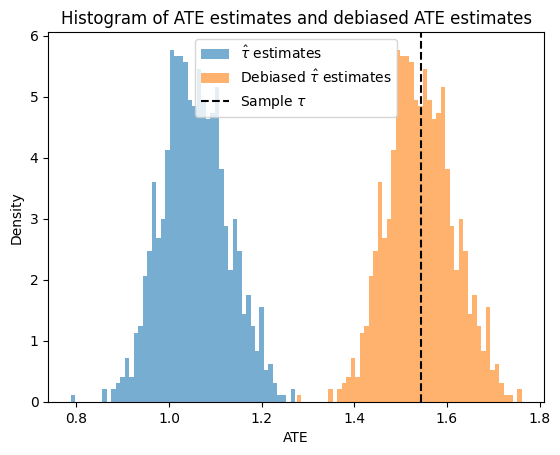

In [26]:
# Plot histograms of tau hats and debiased tau hats
plt.hist(hat_ate_estimates, bins=50, density=True, alpha=0.6, label=r'$\hat{\tau}$ estimates')
plt.hist(hat_ate_estimates - expected_bias, bins=50, density=True, alpha=0.6, label=r'Debiased $\hat{\tau}$ estimates')
plt.axvline(x=ate_estimate, color='k', linestyle='--', label=r'Sample $\tau$')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title('Histogram of ATE estimates and debiased ATE estimates')
plt.legend()
plt.show()

It seems like our way of thinking about this problem with Tweedie's formula is correct! Now we just need to turn $\mathbb{E}[\hat{\tau} \mid \tau]$ into $\mathbb{E}[\tau \mid \hat{\tau}]$.